In [275]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

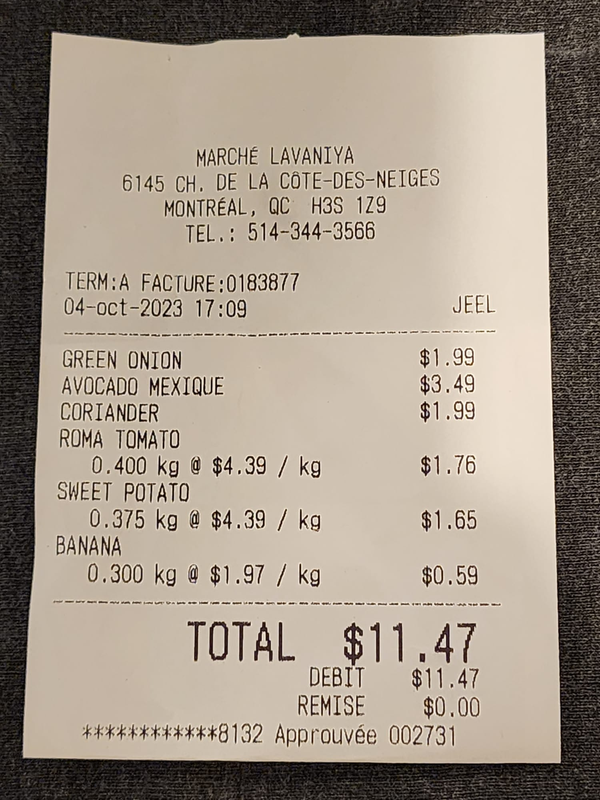

In [276]:
# Sample file out of the dataset
file_name = '../resources/lavaniya_4.jpeg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img

In [277]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [278]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [279]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [280]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

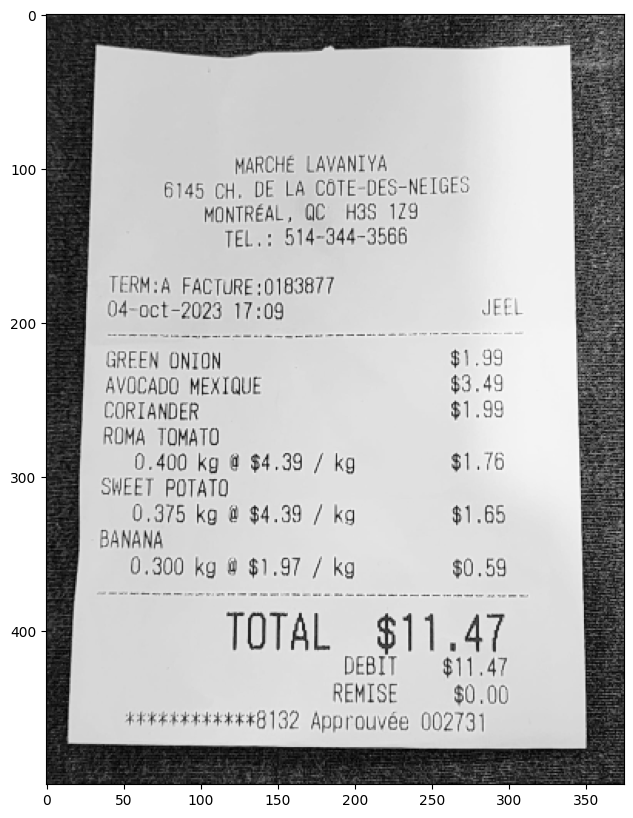

In [281]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

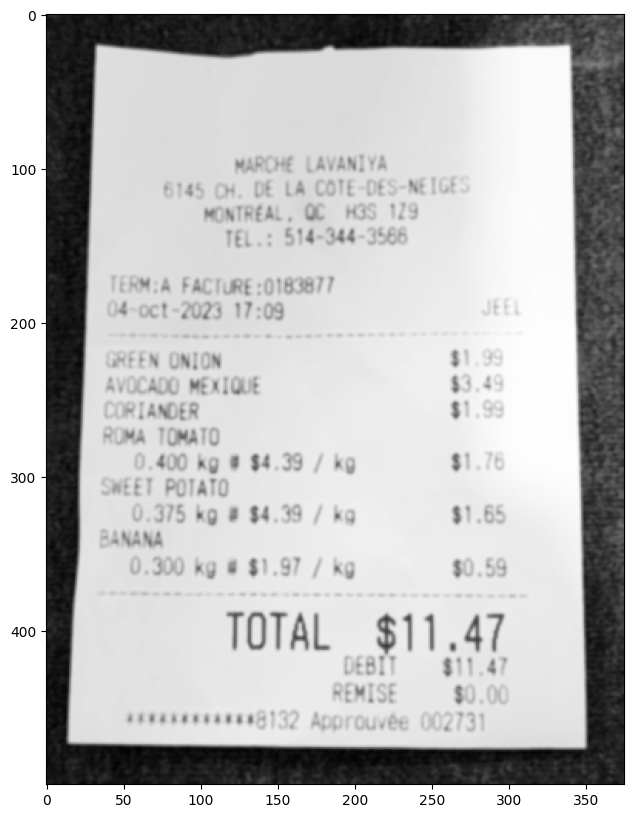

In [282]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

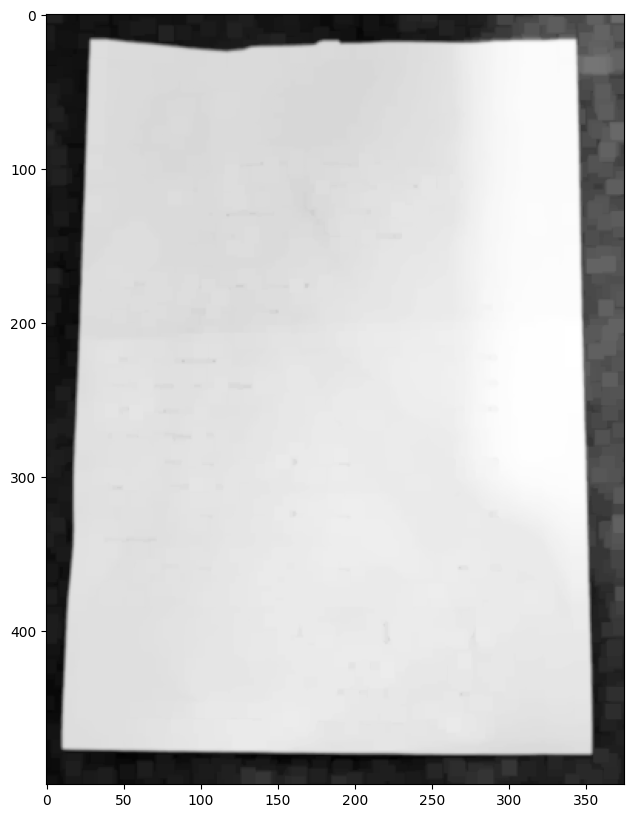

In [283]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9 ))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

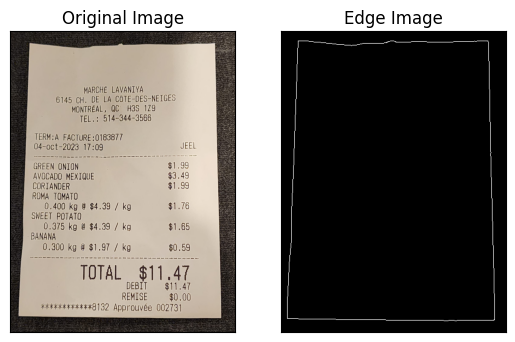

In [284]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edged,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

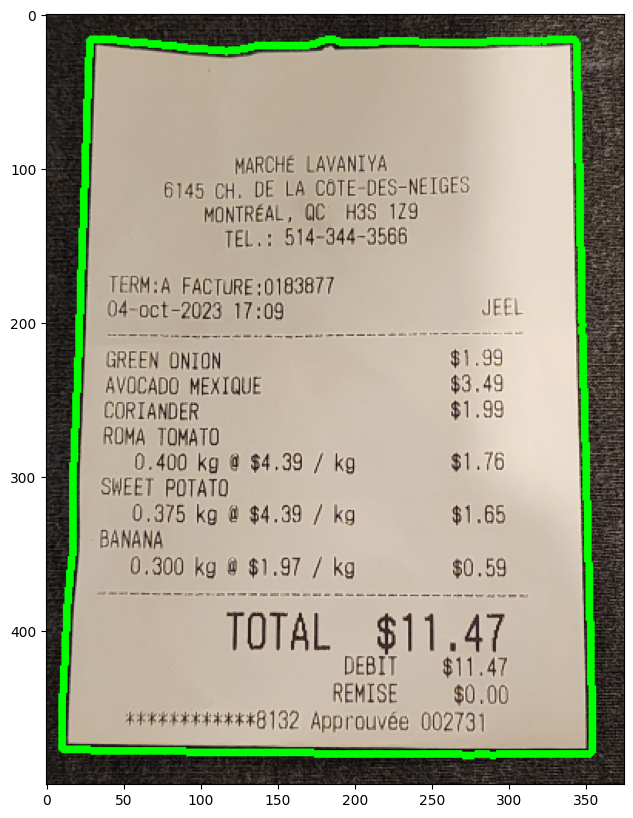

In [285]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

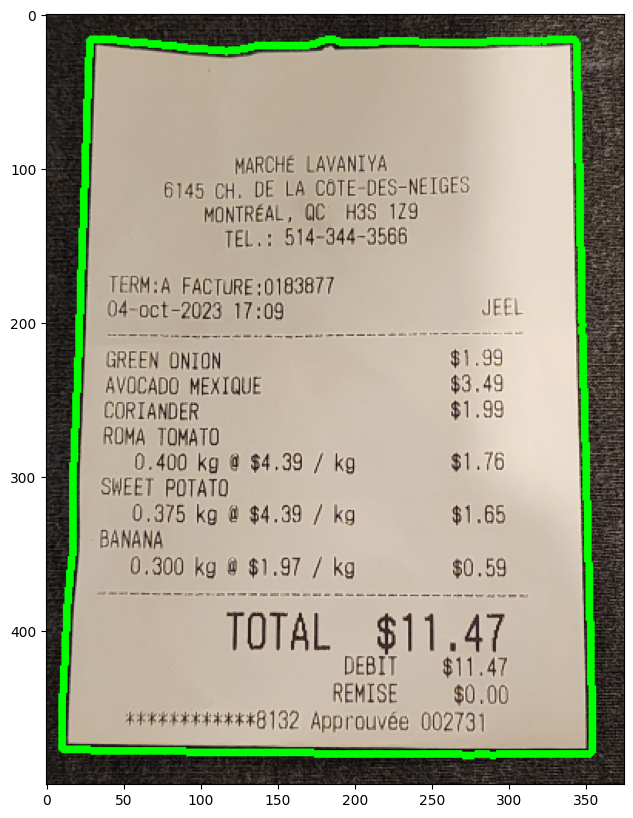

In [286]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [287]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [288]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [289]:
get_receipt_contour(largest_contours)


array([[[ 28,  16]],

       [[ 10, 477]],

       [[353, 480]],

       [[343,  16]]], dtype=int32)

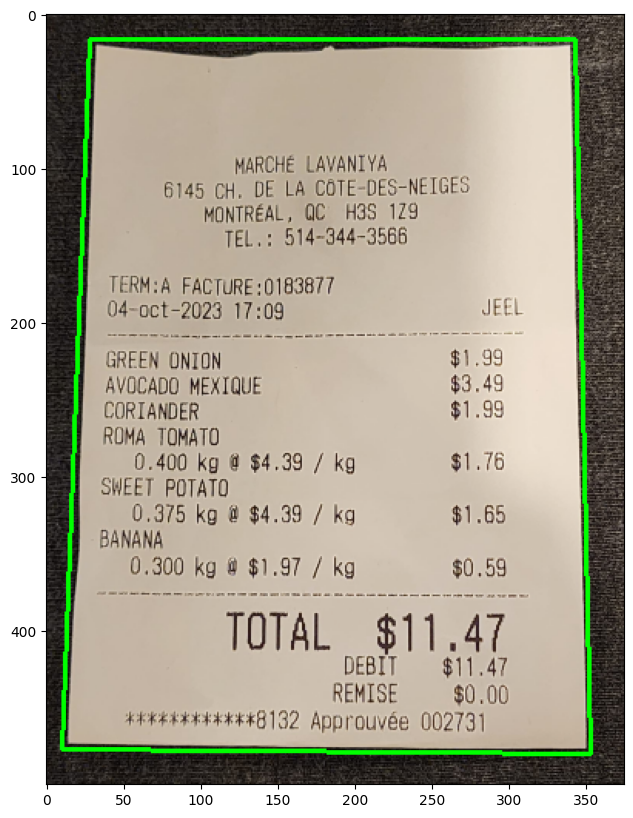

In [290]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0,255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [291]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [292]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

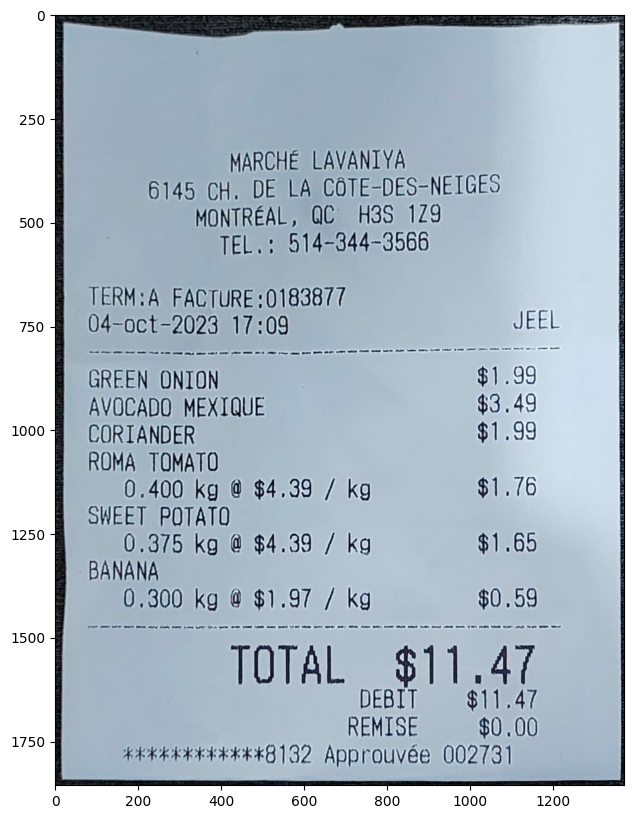

In [293]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [294]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

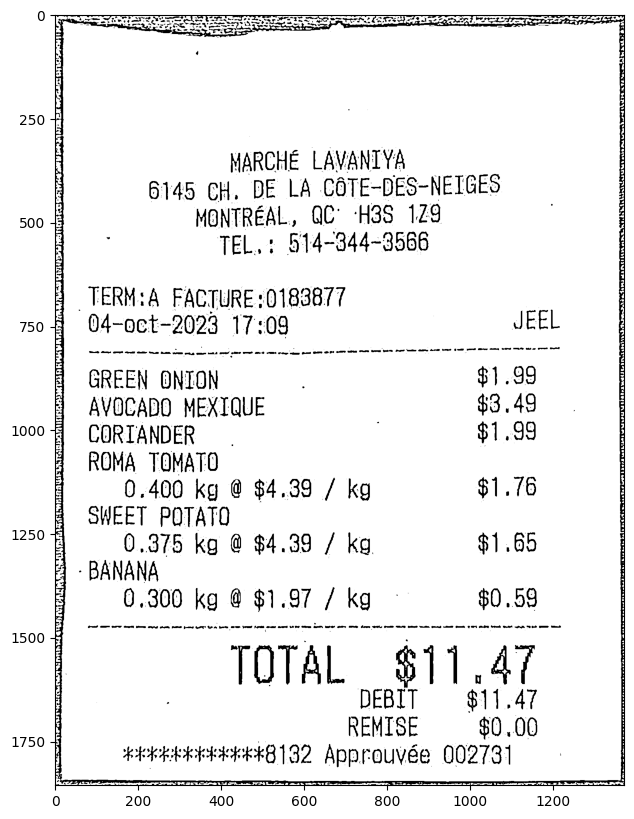

In [295]:
result = bw_scanner(scanned)
plot_gray(result)

In [296]:
output = Image.fromarray(result)
output.save('result.png')

In [297]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [298]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [299]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


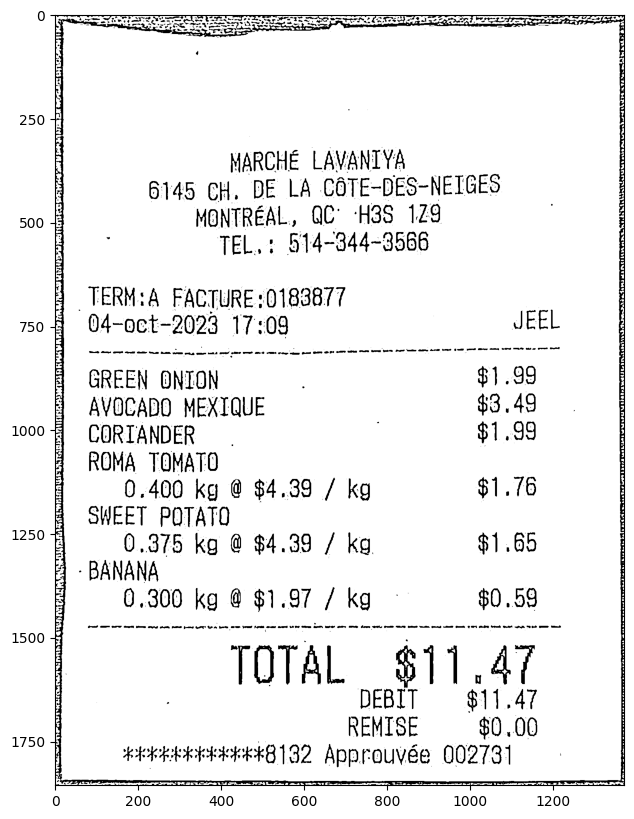

In [300]:
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

111


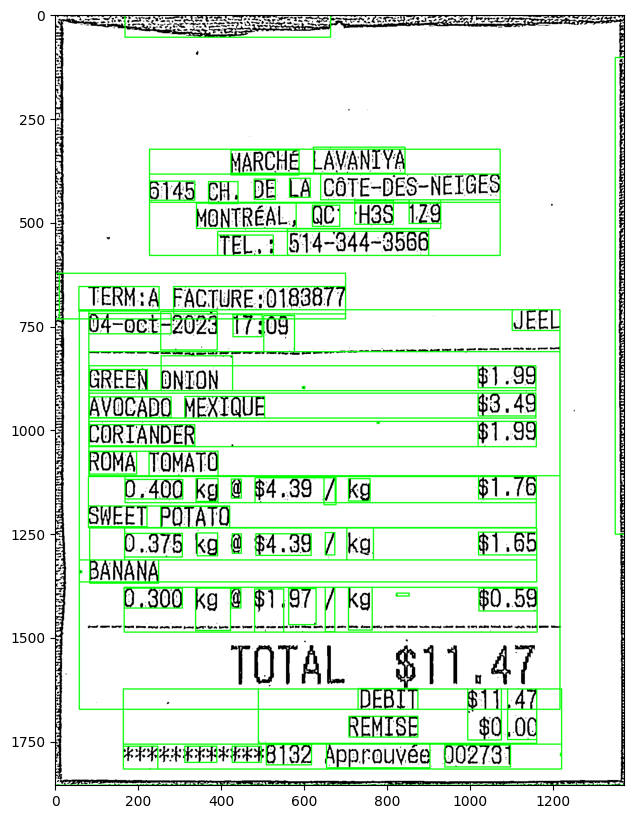

In [301]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
print(n_boxes)
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [302]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

MARCHE LAVANIYA
6145 CH. DE LA COTE-DES-NEIGES
MONTREAL, QC’ -H3S 129
TEL: 514-344-3566

: TERM: FACTURE:0183877

04-oct- ~2023 17: 09 JEEL
GREEN ONION . $1.99
AVOCADO MEXIQUE $3.49
CORIANDER ) $1.99
ROMA TOMATO

0.400 kg @ $4.39 / kg $1.76
SWEET POTATO

0.375 kg @ $4.39 / kg $1.65
- BANANA

0.300 ko @ $1. a7 / kg - $0.59

DEBIT

, REMISE "90 tf
ee AE EEE BII2 Approuvée 002731  -




In [303]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    floats
    unique = list(dict.fromkeys(floats))
    return unique

In [304]:
amounts = find_amounts(extracted_text)
amounts

[1.99, 3.49, 4.39, 1.76, 1.65, 0.59]

In [305]:
pattern = "(.+?)\s+\$([\d.]+)"
items = re.findall(pattern,extracted_text)
items

[('GREEN ONION .', '1.99'),
 ('AVOCADO MEXIQUE', '3.49'),
 ('CORIANDER )', '1.99'),
 ('0.400 kg @', '4.39'),
 (' / kg', '1.76'),
 ('0.375 kg @', '4.39'),
 (' / kg', '1.65'),
 ('0.300 ko @', '1.'),
 (' a7 / kg -', '0.59')]

In [306]:
pattern_amount = "([0-9]+\.[0-9]+)"
item_amount = re.findall(pattern_amount,extracted_text)
item_amount
# print("Price in line items:")
# print("====================")
# for row in extracted_text.split("\n"):
#     if re.search(pattern_amount,row) is not None:
#         print (row)

['1.99',
 '3.49',
 '1.99',
 '0.400',
 '4.39',
 '1.76',
 '0.375',
 '4.39',
 '1.65',
 '0.300',
 '0.59']

In [307]:
type(item_amount)

list